# JHU covid-19 data analysis
Create plots with daily increase per country, inspired by Tomas Pueyo article

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
# import matplotlib.ticker as mticker
import matplotlib.dates as mdates  
import numpy as np
from datetime import timedelta
from matplotlib.dates import date2num    
import matplotlib.dates as dt    

import JHUprocessing as jp
# from JHUprocessing import *

 
# from figure_settings import *

# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# # rc
# plt.rcParams["font.family"] = "Times New Roman"
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

# plt.style.use('latex_scientificPaperStyle.mplstyle')
# dir(rcParams["Font.family"])

# function to merge csv's 

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_time_series'
file_list = ['\\time_series_covid19_confirmed_global.csv',
         '\\time_series_covid19_deaths_global.csv',
         '\\time_series_covid19_recovered_global.csv'] 

df_country = jp.merge_data(path, file_list)  

# import and add measures

In [4]:
# load csv file of measures per country 
df_m = pd.read_csv( "measures_per_country.csv", index_col=None ) 
df_m['Date'] = pd.to_datetime( df_m['Date'] ).dt.date 

# add measures to additional column
for i,row in df_m.iterrows(): 
    country = row['Country/Region']
    date = row['Date']
    bool_loc = (df_country['Country/Region'] == country) & (df_country['Date'] == date) 
    df_country.loc[bool_loc,'Measure'] = row['Measure']

# find daily cases (daily delta)

In [5]:
df_country['Daily Confirmed'] = np.nan
df_country['Daily Death'] = np.nan

days = df_country['Date'].unique()  

bool_day0 = df_country['Date'] == days[0]
df_country.loc[bool_day0,'Daily Confirmed'] = 0
df_country.loc[bool_day0,'Daily Death'] = 0
 
for day in days[1:]:     
    
    bool_day = df_country['Date'] == day 
    bool_prior = df_country['Date'] == ( day- timedelta(days=1))  

    delta = df_country[bool_day]['Confirmed'].values - df_country[bool_prior]['Confirmed'].values
    df_country.loc[bool_day,'Daily Confirmed'] = delta 
    
    
    delta = df_country[bool_day]['Death'].values - df_country[bool_prior]['Death'].values
    df_country.loc[bool_day,'Daily Death'] = delta 
 

# plot daily 

In [6]:
def smooth(x,window_len=11,window='hanning'):
  
    # ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  

In [7]:
def plot_daily( ax_p, date_col, data_series, measures = pd.DataFrame()):
    
    # plotting parameters 
    bar_alpha = .15
    fill_alpha = .2
#     bar_col = '#2b83ba'
#     fill_col ='#e66101'
    
    bar_col = 'k'#np.array([ 1,1,1] )*0.5
    fill_col = 'r'
    bar_line = 'k'
    fill_line = 'r'
#     #ef8a62
#     bar_col = '#67a9cf'
#     fill_col = '#ef8a62'
#     fill_col = '#BF3F3F'
    
    
#     bar_col =  '#af8dc3'
# #f7f7f7
#     fill_col = '#7fbf7b'


    filter_w = 9
    filter_w_delay = 13

    case_delay = 12
    death_delay = 12

    edge_cut = int( np.floor(filter_w/2) ) 
    edge_cut_delay = int( np.floor(filter_w_delay/2) )  
    
    weeks = mdates.DayLocator(bymonthday=[1,11,21], interval=1, tz=None)
    months_fmt = mdates.DateFormatter('%m-%d') 
    #------------------------------------------------------
 
    date_col = date_col.apply(date2num)
    
    
    z_bar= 3
    z_fill = 1
    # smoothen data
    plot_data =  data_series.values  
    plot_data_fake = np.append( plot_data, plot_data[-1]*np.ones((2)) )
    plot_smooth = smooth( plot_data_fake ,filter_w,'hamming' )[edge_cut:-edge_cut-2]
    plot_smooth_delay = smooth( plot_data_fake ,filter_w_delay,'hamming' )[edge_cut_delay:-edge_cut_delay-2]
    
    # plot data
    ax_p.bar( date_col,  plot_data   ,
             alpha = bar_alpha , color=bar_col, 
                label = 'Reported cases', zorder = z_bar) 
    ax_p.plot( date_col, plot_smooth, color=bar_line, zorder = z_bar)
    
    ax_p.plot( date_col.iloc[0:-case_delay] , plot_smooth_delay[case_delay:] , color=fill_line, zorder = z_fill)
    ax_p.fill_between( date_col.iloc[0:-case_delay] , 0, plot_smooth_delay[case_delay:] ,
                      alpha= fill_alpha, color=fill_col, 
                      label='12-day delay', zorder = z_fill
                    )

    # axis modify
    ax_p.xaxis_date()
    ax_p.xaxis.set_major_locator(weeks)
    ax_p.xaxis.set_major_formatter(months_fmt)  
 
    cmax = plot_smooth.max()*1.2  
    ax_p.set_ylim([0,cmax])  
    
    
    arrowprops = dict(
    arrowstyle = "->"    )


    # annotate
    counter = 0
    for i,row in measures.iterrows(): 
        ax_p.plot( [row['Date'],row['Date']] ,[0,cmax],'--', alpha = 0.5,color='k',linewidth=1,zorder  = 6)  
        chinese = ['Hubei','China'] 
        if any(c in measures.iloc[0,:]['Measure'] for c in chinese):
            ax_p.annotate( row['Measure'], (row["Date"],cmax*(0.94-0.1*counter)) ,
                              xytext = ( days[-1],cmax*(0.9-0.1*counter)) ,
                             rotation = 0, va='bottom',ha='right',fontsize=10, arrowprops=arrowprops)   
        else:
            ax_p.annotate( row['Measure'], (row["Date"],cmax*(0.94-0.1*counter)) ,
                              xytext = ( days[0],cmax*(0.9-0.1*counter)) ,
                             rotation = 0, va='bottom',ha='left',fontsize=10, arrowprops=arrowprops)    
        counter = counter+1 
    return ax_p
 

# plot world cases 

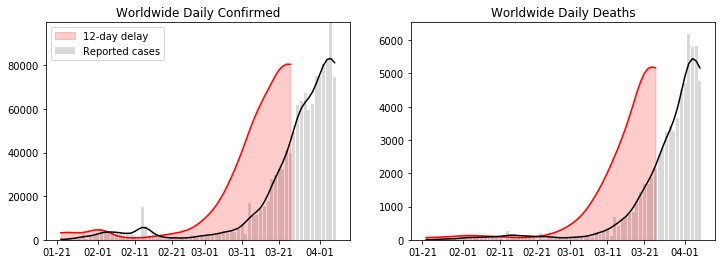

In [8]:
# .apply(date2num)  
# make plot dataframe
df_pl = df_country.groupby( 'Date').sum() 
df_pl['Date'] = df_pl.index  

fig, ax = plt.subplots(1 ,2,figsize=(full_w[0],4))

ax[0] = plot_daily( ax[0] , df_pl['Date'], df_pl['Daily Confirmed'] )
ax[1] = plot_daily( ax[1] , df_pl['Date'], df_pl['Daily Death'] )

ax[0].set_title('Worldwide Daily Confirmed')
ax[1].set_title('Worldwide Daily Deaths')  
ax[0].legend( )

# Sort countries

In [9]:
# sort countries by confirmed cases on last date
bool_last = df_country['Date'] == df_country['Date'].max()
sorted_countries = df_country[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_countries.head(5)  

,Country/Region,Date,Confirmed,Death,Recovered,Measure,Daily Confirmed,Daily Death
12824,US,2020-04-05,337072,9619,17448.0,NaN,28222.0,1212.0
11699,Spain,2020-04-05,131646,12641,2.0,NaN,5478.0,694.0
6374,Italy,2020-04-05,128948,15887,6463.0,NaN,4316.0,525.0
4949,Germany,2020-04-05,100123,1584,1.0,NaN,4031.0,140.0
4649,France,2020-04-05,93773,8093,45053.0,NaN,2925.0,519.0


# plot top countries 

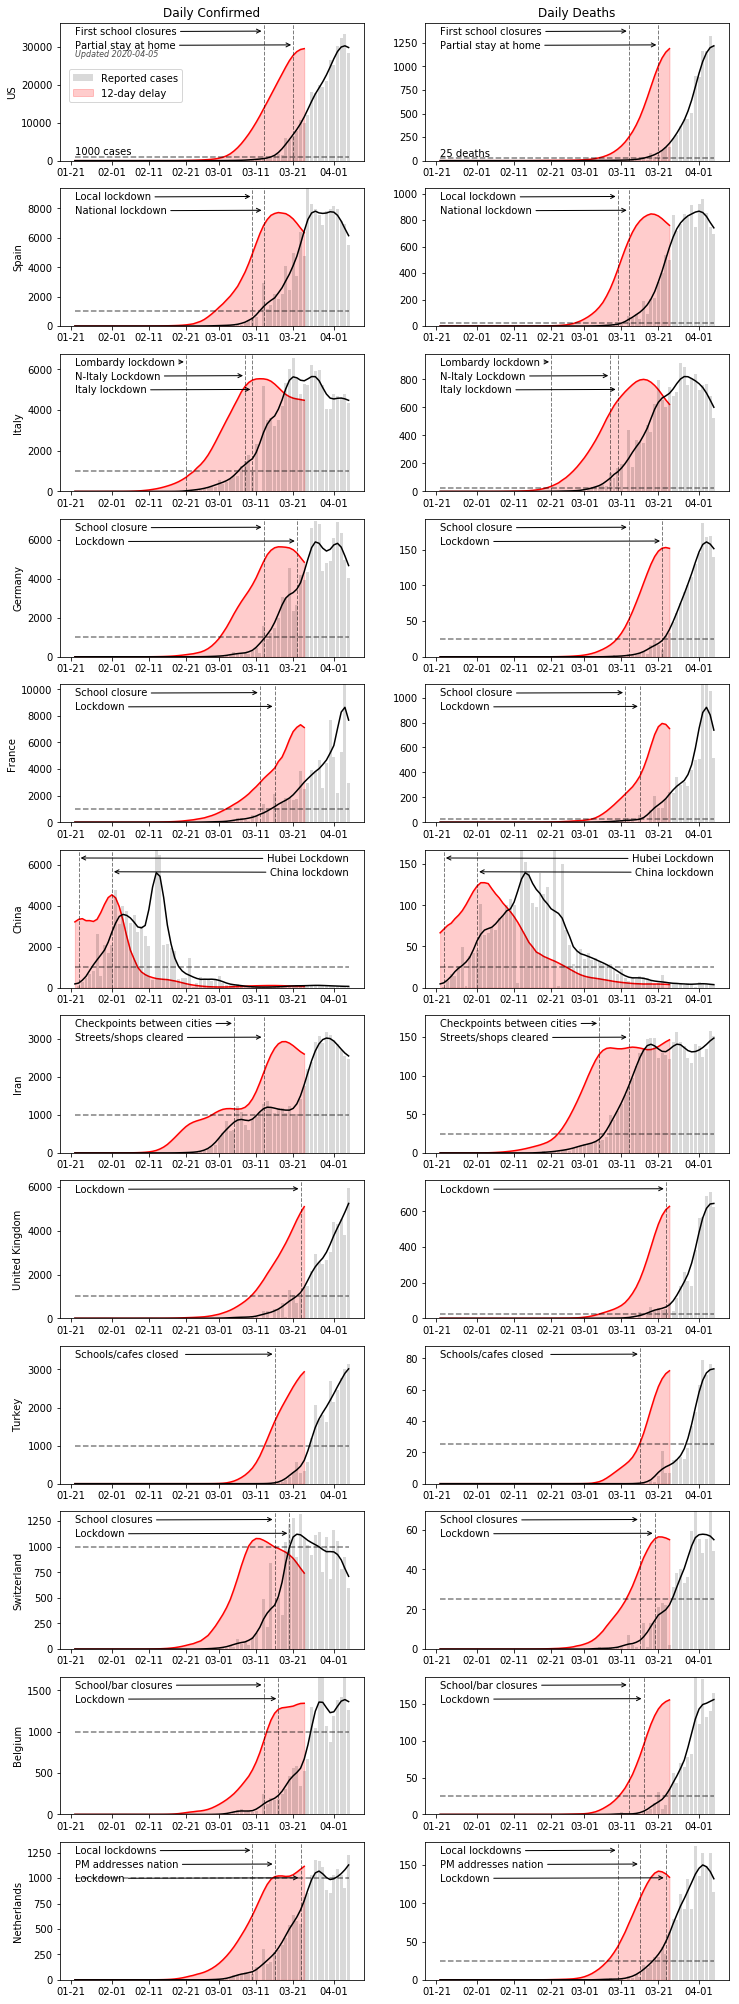

In [10]:
n_countries = 12
top_countries = sorted_countries['Country/Region'][:n_countries].tolist()

dates = df_pl['Date' ].unique() 
fig, ax = plt.subplots(n_countries ,2,figsize=( full_w[0],n_countries*3))
 
for i,country in enumerate( top_countries ):
    df_pl = df_country[ df_country['Country/Region'] == country]
#     df_pl['Date'] = df_pl.index  
#     df_pl['Date'] = df_pl['Date'].apply(date2num)
    
    bool_measure = df_pl['Measure'].notnull() 
    measures= df_pl.loc[bool_measure,['Measure','Date']] 
     
    plot_daily( ax[i,0] , df_pl['Date'], df_pl['Daily Confirmed'], measures)
    plot_daily( ax[i,1] , df_pl['Date'], df_pl['Daily Death'],measures)
 
    # add comparison lines  
    ax[i,0].plot( dates[[0,len(days)-1]], [1000,1000],'--',color='k', alpha = 0.5 )
    ax[i,1].plot( dates[[0,len(days)-1]], [25,25],'--',color='k', alpha = 0.5 ) 
    ax[i,0].set_ylabel( country )
      
ax[0,0].set_title('Daily Confirmed')
ax[0,1].set_title('Daily Deaths') 

# reverse the order
# handles, labels = ax[0,0].get_legend_handles_labels()
# ax[0,0].legend(handles[::-1], labels[::-1])
# ax[0,0].legend(  bbox_to_anchor=(0.42, .7))  
ax[0,0].legend(  ax[0,0].get_legend_handles_labels()[0][::-1] , 
               ax[0,0].get_legend_handles_labels()[1] [::-1],
               bbox_to_anchor=(0.42, .7))


ax[0,0].annotate('1000 cases',[dates[0],1000*1.5])
ax[0,1].annotate('25 deaths',[dates[0],25*1.5])


ax[0,0].annotate('Updated '+str( df_country['Date'].iloc[-1]), 
            [dt.date2num( dates[0] ) ,df_country['Daily Confirmed'].max()*(0.94-0.12)], 
                 color=[.3,.3,.3], style='italic',fontsize=8)




# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_dailycases'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

In [11]:
 df_country['Daily Confirmed'].max() 

33264.0